# Imports

In [1]:
import shap
import optuna

import numpy   as np
import pandas  as pd
import seaborn as sns
import category_encoders as ce

import matplotlib.pyplot as plt

from mrmr import mrmr_regression

from xgboost  import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from feature_engine import encoding
from feature_engine import creation
from feature_engine import imputation

from sklearn.metrics           import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection   import cross_validate
from sklearn.feature_selection import SelectFromModel

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Functions

In [2]:
random_state = 42
np.random.seed(random_state)

In [3]:
def jupyter_settings():
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 500

jupyter_settings()

In [4]:
def get_cross_validate_metrics(dict_cv_result):

    print(f"""
    R2 test mean: {dict_cv_result['test_r2'].mean()}; 
    R2 test std: {dict_cv_result['test_r2'].std()}

    MAE test mean: {dict_cv_result['test_mae'].mean()}; 
    MAE test std: {dict_cv_result['test_mae'].std()}
    
    RMSE test mean: {dict_cv_result['test_rmse'].mean()}; 
    RMSE test std: {dict_cv_result['test_rmse'].std()}
    """)

In [5]:
def get_metrics(y_true, y_pred):

    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f"R2: {r2}; RMSE: {rmse}; MAE: {mae}; MAPE: {mape}")

In [6]:
def do_hyperparameter_tuning(estimator, optuna_params, X, y, n_trials, scoring, random_state=42, cv=3, n_jobs=-1):

    optuna_search = optuna.integration.OptunaSearchCV(
        estimator=estimator, 
        param_distributions=optuna_params, 
        cv=cv, 
        n_jobs=n_jobs, 
        n_trials=n_trials, 
        scoring=scoring,
        random_state=random_state,
        verbose=0)

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    optuna_search.fit(X, y)

    return optuna_search, optuna_search.best_params_, optuna_search.best_score_

# Loading Datasets

In [7]:
df_train = pd.read_parquet('../data/processed/df_train_from_2.2_exploratory_data_analysis.parquet')
df_oot = pd.read_parquet('../data/processed/df_oot_from_2.2_exploratory_data_analysis.parquet')

## Columns

In [8]:
df_train.columns.tolist()

['order_purchase_timestamp',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'customer_lat',
 'customer_lng',
 'seller_geolocation_city_count',
 'seller_geolocation_city_nunique',
 'seller_geolocation_city_size',
 'seller_geolocation_city_mode',
 'seller_geolocation_state_count',
 'seller_geolocation_state_nunique',
 'seller_geolocation_state_size',
 'seller_geolocation_state_mode',
 'distance_customer_seller_count',
 'distance_customer_seller_min',
 'distance_customer_seller_max',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q25',
 'distance_customer_seller_q75',
 'distance_customer_seller_range',
 'payment_sequential_count',
 'payment_sequential_min',
 'payment_sequential_max',
 'payment_sequential_mean',
 'payment_sequential_median',
 'payment_sequential_q25',
 'payment_sequential_q75',
 'payment_sequential_range',
 'payment_type_count',
 'paymen

In [9]:
df_oot.columns.tolist()

['order_purchase_timestamp',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'customer_lat',
 'customer_lng',
 'seller_geolocation_city_count',
 'seller_geolocation_city_nunique',
 'seller_geolocation_city_size',
 'seller_geolocation_city_mode',
 'seller_geolocation_state_count',
 'seller_geolocation_state_nunique',
 'seller_geolocation_state_size',
 'seller_geolocation_state_mode',
 'distance_customer_seller_count',
 'distance_customer_seller_min',
 'distance_customer_seller_max',
 'distance_customer_seller_mean',
 'distance_customer_seller_median',
 'distance_customer_seller_q25',
 'distance_customer_seller_q75',
 'distance_customer_seller_range',
 'payment_sequential_count',
 'payment_sequential_min',
 'payment_sequential_max',
 'payment_sequential_mean',
 'payment_sequential_median',
 'payment_sequential_q25',
 'payment_sequential_q75',
 'payment_sequential_range',
 'payment_type_count',
 'paymen

## Data Dimensions

In [10]:
print('Number of Rows: {}'.format(df_train.shape[0]))
print('Number of Cols: {}'.format(df_train.shape[1]))

Number of Rows: 77853
Number of Cols: 147


In [11]:
print('Number of Rows: {}'.format(df_oot.shape[0]))
print('Number of Cols: {}'.format(df_oot.shape[1]))

Number of Rows: 18603
Number of Cols: 147


## Data Types

In [12]:
df_train.dtypes

order_purchase_timestamp                    datetime64[ns]
order_delivered_customer_date               datetime64[ns]
order_estimated_delivery_date               datetime64[ns]
customer_zip_code_prefix                            object
customer_city                                       object
customer_state                                      object
customer_lat                                       float64
customer_lng                                       float64
seller_geolocation_city_count                        int64
seller_geolocation_city_nunique                      int64
seller_geolocation_city_size                         int64
seller_geolocation_city_mode                        object
seller_geolocation_state_count                       int64
seller_geolocation_state_nunique                     int64
seller_geolocation_state_size                        int64
seller_geolocation_state_mode                       object
distance_customer_seller_count                       int

In [13]:
df_oot.dtypes

order_purchase_timestamp                    datetime64[ns]
order_delivered_customer_date               datetime64[ns]
order_estimated_delivery_date               datetime64[ns]
customer_zip_code_prefix                            object
customer_city                                       object
customer_state                                      object
customer_lat                                       float64
customer_lng                                       float64
seller_geolocation_city_count                        int64
seller_geolocation_city_nunique                      int64
seller_geolocation_city_size                         int64
seller_geolocation_city_mode                        object
seller_geolocation_state_count                       int64
seller_geolocation_state_nunique                     int64
seller_geolocation_state_size                        int64
seller_geolocation_state_mode                       object
distance_customer_seller_count                       int

## Check NA

In [14]:
df_train.isna().mean()

order_purchase_timestamp                    0.000000
order_delivered_customer_date               0.000000
order_estimated_delivery_date               0.000000
customer_zip_code_prefix                    0.000000
customer_city                               0.000000
customer_state                              0.000000
customer_lat                                0.002697
customer_lng                                0.002697
seller_geolocation_city_count               0.000000
seller_geolocation_city_nunique             0.000000
seller_geolocation_city_size                0.000000
seller_geolocation_city_mode                0.002440
seller_geolocation_state_count              0.000000
seller_geolocation_state_nunique            0.000000
seller_geolocation_state_size               0.000000
seller_geolocation_state_mode               0.002453
distance_customer_seller_count              0.000000
distance_customer_seller_min                0.005112
distance_customer_seller_max                0.

In [15]:
df_oot.isna().mean()

order_purchase_timestamp                    0.000000
order_delivered_customer_date               0.000000
order_estimated_delivery_date               0.000000
customer_zip_code_prefix                    0.000000
customer_city                               0.000000
customer_state                              0.000000
customer_lat                                0.002903
customer_lng                                0.002903
seller_geolocation_city_count               0.000000
seller_geolocation_city_nunique             0.000000
seller_geolocation_city_size                0.000000
seller_geolocation_city_mode                0.001398
seller_geolocation_state_count              0.000000
seller_geolocation_state_nunique            0.000000
seller_geolocation_state_size               0.000000
seller_geolocation_state_mode               0.001398
distance_customer_seller_count              0.000000
distance_customer_seller_min                0.004193
distance_customer_seller_max                0.

## Splitting into X and y

In [16]:
list_columns = [
    'order_purchase_timestamp', 'order_delivered_customer_date', 
    'order_estimated_delivery_date', 'delivered_in_days', 'estimated_delivery_in_days', 'time']

X_train = df_train.drop(columns=list_columns)
X_oot = df_oot.drop(columns=list_columns)

In [17]:
target = 'delivered_in_days'
list_columns = ['delivered_in_days', 'estimated_delivery_in_days']

y_train = df_train.loc[:, list_columns]
y_oot = df_oot.loc[:, list_columns]

# Feature Engineering

## Categorical Encoding

In [18]:
categorical_variables = X_train.select_dtypes(include='object').columns.tolist()
categorical_variables

['customer_zip_code_prefix',
 'customer_city',
 'customer_state',
 'seller_geolocation_city_mode',
 'seller_geolocation_state_mode',
 'payment_type_mode',
 'product_category_name_mode']

In [19]:
target_encoder = ce.TargetEncoder(
    cols=categorical_variables, return_df=True, handle_missing='value', handle_unknown='value')

X_train = target_encoder.fit_transform(X_train, y_train[target])
X_oot = target_encoder.transform(X_oot)

## Removing Features

In [20]:
list_selected_features_rmrm = mrmr_regression(X=X_train, y=y_train[target], K=50)

100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.67it/s]


# Machine Learning Modeling

## LightGBM Regressor

### First Hyperparameter Tuning

In [21]:
%%time

optuna_params = {
    "n_estimators": optuna.distributions.IntDistribution(100, 1100, 100),
    "learning_rate": optuna.distributions.FloatDistribution(1e-3, 0.1, log=True),
    "num_leaves": optuna.distributions.IntDistribution(2, 2**10),
    "subsample": optuna.distributions.FloatDistribution(0.05, 1.0),
    "colsample_bytree": optuna.distributions.FloatDistribution(0.05, 1.0),
    "min_data_in_leaf": optuna.distributions.IntDistribution(1, 100)}

model = LGBMRegressor(
    objective='regression',
    metric='rmse',
    verbosity=-1,
    bagging_freq=1,
    random_state=random_state)

optuna_search, best_params, best_score = do_hyperparameter_tuning(
    estimator=model, optuna_params=optuna_params, X=X_train[list_selected_features_rmrm], y=y_train[target], 
    n_trials=50, scoring='neg_root_mean_squared_error')

print('Best hyperparameters:', best_params)
print('Best RMSE:', best_score)

Best hyperparameters: {'n_estimators': 377, 'learning_rate': 0.018352272432160522, 'num_leaves': 104, 'subsample': 0.743822914572438, 'colsample_bytree': 0.7774217044159573, 'min_data_in_leaf': 38}
Best RMSE: -7.654445667969807
CPU times: user 1h 44min 42s, sys: 1h 11min 16s, total: 2h 55min 59s
Wall time: 15min 39s


In [22]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'bagging_freq': 1,
    'random_state': random_state,
    'n_estimators': 377, 
    'learning_rate': 0.018352272432160522, 
    'num_leaves': 104, 
    'subsample': 0.743822914572438, 
    'colsample_bytree': 0.7774217044159573, 
    'min_data_in_leaf': 38}

lgbm = LGBMRegressor(**params)
lgbm.fit(X_train[list_selected_features_rmrm], y_train[target])

y_oot['pred'] = lgbm.predict(X_oot[list_selected_features_rmrm])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.07179372189779176; RMSE: 6.011802853360572; MAE: 4.442919808724309; MAPE: 125999609198013.39


### Feature Selection

In [23]:
sfm = SelectFromModel(estimator=LGBMRegressor(**params, n_jobs=-1))
sfm.fit(X_train[list_selected_features_rmrm], y_train[target])

list_selected_features = X_train[list_selected_features_rmrm].loc[:, sfm.get_support()].columns.tolist()
list_selected_features

['customer_zip_code_prefix',
 'seller_geolocation_city_mode',
 'distance_customer_seller_mean',
 'customer_city',
 'customer_state',
 'distance_customer_seller_min',
 'product_category_name_mode',
 'freight_value_min',
 'order_approved_at_second',
 'customer_lat',
 'customer_lng',
 'order_purchase_timestamp_month',
 'seller_geolocation_state_mode',
 'product_length_cm_min',
 'product_weight_g_min',
 'payment_value_q75',
 'order_approved_at_month',
 'product_height_cm_min']

In [24]:
lgbm = LGBMRegressor(**params)
lgbm.fit(X_train[list_selected_features], y_train[target])

y_oot['pred'] = lgbm.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.07529806283908225; RMSE: 6.021622940013304; MAE: 4.457302202077179; MAPE: 124136373594597.39


### Second Hyperparamenter Tuning

In [25]:
%%time

optuna_params = {
    "n_estimators": optuna.distributions.IntDistribution(100, 1100, 100),
    "learning_rate": optuna.distributions.FloatDistribution(1e-3, 0.1, log=True),
    "num_leaves": optuna.distributions.IntDistribution(2, 2**10),
    "subsample": optuna.distributions.FloatDistribution(0.05, 1.0),
    "colsample_bytree": optuna.distributions.FloatDistribution(0.05, 1.0),
    "min_data_in_leaf": optuna.distributions.IntDistribution(1, 100)}

model = LGBMRegressor(
    objective='regression',
    metric='rmse',
    verbosity=-1,
    bagging_freq=1,
    random_state=random_state)

optuna_search, best_params, best_score = do_hyperparameter_tuning(
    estimator=model, optuna_params=optuna_params, X=X_train[list_selected_features], y=y_train[target], 
    n_trials=50, scoring='neg_root_mean_squared_error')

print('Best hyperparameters:', best_params)
print('Best RMSE:', best_score)

Best hyperparameters: {'n_estimators': 652, 'learning_rate': 0.01313361903066501, 'num_leaves': 629, 'subsample': 0.49103008156010314, 'colsample_bytree': 0.39953700199463205, 'min_data_in_leaf': 26}
Best RMSE: -7.656399723792383
CPU times: user 39min 17s, sys: 35min 18s, total: 1h 14min 36s
Wall time: 6min 46s


In [26]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'bagging_freq': 1,
    'random_state': random_state,
    'n_estimators': 652, 
    'learning_rate': 0.01313361903066501, 
    'num_leaves': 629, 
    'subsample': 0.49103008156010314, 
    'colsample_bytree': 0.39953700199463205, 
    'min_data_in_leaf': 26}

lgbm = LGBMRegressor(**params)
lgbm.fit(X_train[list_selected_features], y_train[target])

y_oot['pred'] = lgbm.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.07962828965210544; RMSE: 6.033735300171035; MAE: 4.466858769673264; MAPE: 116232864239143.45


## CatBoost Regressor

### First Hyperparameter Tuning

In [27]:
%%time

optuna_params = {
    "learning_rate": optuna.distributions.FloatDistribution(1e-3, 0.1, log=True),
    "depth": optuna.distributions.IntDistribution(1, 10),
    "subsample": optuna.distributions.FloatDistribution(0.05, 1.0),
    "colsample_bylevel": optuna.distributions.FloatDistribution(0.05, 1.0),
    "min_data_in_leaf": optuna.distributions.IntDistribution(1, 100)}

model = CatBoostRegressor(iterations=1000, silent=True)

optuna_search, best_params, best_score = do_hyperparameter_tuning(
    estimator=model, optuna_params=optuna_params, X=X_train[list_selected_features_rmrm], y=y_train[target], 
    n_trials=30, scoring='neg_root_mean_squared_error')

print('Best hyperparameters:', best_params)
print('Best RMSE:', best_score)

Best hyperparameters: {'learning_rate': 0.060286175793317104, 'depth': 7, 'subsample': 0.5599086890727357, 'colsample_bylevel': 0.1623788787333098, 'min_data_in_leaf': 84}
Best RMSE: -7.685336632441977
CPU times: user 1h 39s, sys: 1h 48s, total: 2h 1min 28s
Wall time: 11min 1s


In [28]:
params = {
    'iterations': 1000,
    'silent': True,
    'learning_rate': 0.060286175793317104, 
    'depth': 7, 
    'subsample': 0.5599086890727357, 
    'colsample_bylevel': 0.1623788787333098, 
    'min_data_in_leaf': 84}

cat = CatBoostRegressor(**params)
cat.fit(X_train[list_selected_features_rmrm], y_train[target])

y_oot['pred'] = cat.predict(X_oot[list_selected_features_rmrm])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.08932131493374129; RMSE: 6.060760556822154; MAE: 4.468537568460436; MAPE: 121550172434838.03


### Feature Selection

In [29]:
sfm = SelectFromModel(estimator=CatBoostRegressor(**params))
sfm.fit(X_train[list_selected_features_rmrm], y_train[target])

list_selected_features = X_train[list_selected_features_rmrm].loc[:, sfm.get_support()].columns.tolist()
list_selected_features

['customer_zip_code_prefix',
 'seller_geolocation_city_mode',
 'customer_city',
 'customer_state',
 'distance_customer_seller_min',
 'customer_lat',
 'customer_lng',
 'order_purchase_timestamp_month',
 'seller_geolocation_state_mode',
 'order_approved_at_month']

In [30]:
cat = CatBoostRegressor(**params)
cat.fit(X_train[list_selected_features], y_train[target])

y_oot['pred'] = cat.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.0427961388061755; RMSE: 5.929919981511111; MAE: 4.355921258326677; MAPE: 122981273369584.48


### Second Hyperparameter Tuning

In [31]:
%%time

optuna_params = {
    "learning_rate": optuna.distributions.FloatDistribution(1e-3, 0.1, log=True),
    "depth": optuna.distributions.IntDistribution(1, 10),
    "subsample": optuna.distributions.FloatDistribution(0.05, 1.0),
    "colsample_bylevel": optuna.distributions.FloatDistribution(0.05, 1.0),
    "min_data_in_leaf": optuna.distributions.IntDistribution(1, 100)}

model = CatBoostRegressor(iterations=1000, silent=True)

optuna_search, best_params, best_score = do_hyperparameter_tuning(
    estimator=model, optuna_params=optuna_params, X=X_train[list_selected_features], y=y_train[target], 
    n_trials=60, scoring='neg_root_mean_squared_error')

print('Best hyperparameters:', best_params)
print('Best RMSE:', best_score)

Best hyperparameters: {'learning_rate': 0.055383865091099535, 'depth': 10, 'subsample': 0.25035844463939977, 'colsample_bylevel': 0.18844247623059476, 'min_data_in_leaf': 1}
Best RMSE: -7.697542360443568
CPU times: user 38min 36s, sys: 6min 6s, total: 44min 43s
Wall time: 4min 1s


In [34]:
params = {
    'iterations': 1000,
    'silent': True,
    'learning_rate': 0.055383865091099535, 
    'depth': 10, 
    'subsample': 0.25035844463939977, 
    'colsample_bylevel': 0.18844247623059476, 
    'min_data_in_leaf': 1}

cat = CatBoostRegressor(**params)
cat.fit(X_train[list_selected_features], y_train[target])

y_oot['pred'] = cat.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.05179777103893324; RMSE: 5.955459133810177; MAE: 4.37434664616333; MAPE: 124122490917478.58


## XGBoost Regressor

### First Hyperparameter Tuning

In [35]:
%%time

optuna_params = {
    "n_estimators": optuna.distributions.IntDistribution(100, 1100, 100),
    "learning_rate": optuna.distributions.FloatDistribution(1e-3, 0.1, log=True),
    "max_depth": optuna.distributions.IntDistribution(1, 10),
    "subsample": optuna.distributions.FloatDistribution(0.05, 1.0),
    "colsample_bytree": optuna.distributions.FloatDistribution(0.05, 1.0),
    "min_child_weight": optuna.distributions.IntDistribution(1, 20)}

model = XGBRegressor()

optuna_search, best_params, best_score = do_hyperparameter_tuning(
    estimator=model, optuna_params=optuna_params, X=X_train[list_selected_features_rmrm], y=y_train[target], 
    n_trials=50, scoring='neg_root_mean_squared_error')

print('Best hyperparameters:', best_params)
print('Best RMSE:', best_score)

Best hyperparameters: {'n_estimators': 399, 'learning_rate': 0.022801397613232532, 'max_depth': 7, 'subsample': 0.7325501463107914, 'colsample_bytree': 0.32394867914670084, 'min_child_weight': 6}
Best RMSE: -7.68717102907594
CPU times: user 1h 10min 4s, sys: 7min 24s, total: 1h 17min 28s
Wall time: 6min 58s


In [36]:
params = {
    'n_estimators': 399, 
    'learning_rate': 0.022801397613232532, 
    'max_depth': 7, 
    'subsample': 0.7325501463107914, 
    'colsample_bytree': 0.32394867914670084, 
    'min_child_weight': 6}

xgb = XGBRegressor(**params)
xgb.fit(X_train[list_selected_features_rmrm], y_train[target], verbose=False)

y_oot['pred'] = xgb.predict(X_oot[list_selected_features_rmrm])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.06565927762776602; RMSE: 5.994573796131497; MAE: 4.446164855974717; MAPE: 122029461184231.52


### Feature Selecion

In [37]:
sfm = SelectFromModel(estimator=XGBRegressor(**params))
sfm.fit(X_train[list_selected_features_rmrm], y_train[target])

list_selected_features = X_train[list_selected_features_rmrm].loc[:, sfm.get_support()].columns.tolist()
list_selected_features

['customer_zip_code_prefix',
 'seller_geolocation_city_mode',
 'distance_customer_seller_mean',
 'customer_city',
 'customer_state',
 'distance_customer_seller_min',
 'distance_customer_seller_q25',
 'distance_customer_seller_median',
 'distance_customer_seller_q75',
 'freight_value_min',
 'freight_value_median',
 'order_purchase_timestamp_month',
 'order_approved_at_month']

In [38]:
xgb = XGBRegressor(**params)
xgb.fit(X_train[list_selected_features], y_train[target], verbose=False)

y_oot['pred'] = xgb.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.052317691928311705; RMSE: 5.9569308925184465; MAE: 4.422580558523301; MAPE: 118371504053310.7


### Second Hyperparameter Tuning

In [39]:
%%time

optuna_params = {
    "n_estimators": optuna.distributions.IntDistribution(100, 1100, 100),
    "learning_rate": optuna.distributions.FloatDistribution(1e-3, 0.1, log=True),
    "max_depth": optuna.distributions.IntDistribution(1, 10),
    "subsample": optuna.distributions.FloatDistribution(0.05, 1.0),
    "colsample_bytree": optuna.distributions.FloatDistribution(0.05, 1.0),
    "min_child_weight": optuna.distributions.IntDistribution(1, 20)}

model = XGBRegressor()

optuna_search, best_params, best_score = do_hyperparameter_tuning(
    estimator=model, optuna_params=optuna_params, X=X_train[list_selected_features], y=y_train[target], 
    n_trials=100, scoring='neg_root_mean_squared_error')

print('Best hyperparameters:', best_params)
print('Best RMSE:', best_score)

Best hyperparameters: {'n_estimators': 537, 'learning_rate': 0.011769293348262247, 'max_depth': 9, 'subsample': 0.6557850728025237, 'colsample_bytree': 0.6274339142887732, 'min_child_weight': 20}
Best RMSE: -7.700784518501718
CPU times: user 1h 12min 45s, sys: 13min 33s, total: 1h 26min 18s
Wall time: 7min 44s


In [40]:
params = {
    'n_estimators': 537, 
    'learning_rate': 0.011769293348262247, 
    'max_depth': 9, 
    'subsample': 0.6557850728025237, 
    'colsample_bytree': 0.6274339142887732, 
    'min_child_weight': 20}

xgb = XGBRegressor(**params)
xgb.fit(X_train[list_selected_features], y_train[target])

y_oot['pred'] = xgb.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.06765336434957736; RMSE: 6.000179768638498; MAE: 4.449126617803257; MAPE: 120067126169892.66


# Result Analysis

## Final Model

In [58]:
list_selected_features = [
    'customer_zip_code_prefix',
    'seller_geolocation_city_mode',
    'distance_customer_seller_mean',
    'customer_city',
    'customer_state',
    'distance_customer_seller_min',
    'product_category_name_mode',
    'freight_value_min',
    'order_approved_at_second',
    'customer_lat',
    'customer_lng',
    'order_purchase_timestamp_month',
    'seller_geolocation_state_mode',
    'product_length_cm_min',
    'product_weight_g_min',
    'payment_value_q75',
    'order_approved_at_month',
    'product_height_cm_min']

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'bagging_freq': 1,
    'random_state': random_state,
    'n_estimators': 652, 
    'learning_rate': 0.01313361903066501, 
    'num_leaves': 629, 
    'subsample': 0.49103008156010314, 
    'colsample_bytree': 0.39953700199463205, 
    'min_data_in_leaf': 26}

dict_cv_results = cross_validate(
    LGBMRegressor(**params), X=X_train[list_selected_features], y=y_train[target], 
    scoring={'r2': 'r2', 'mae': 'neg_mean_absolute_error', 'rmse': 'neg_root_mean_squared_error'}, 
    cv=3, n_jobs=-1)

get_cross_validate_metrics(dict_cv_results)


    R2 test mean: 0.41186819825765947; 
    R2 test std: 0.003711198654114777

    MAE test mean: -4.6676726982880785; 
    MAE test std: 0.030069693803004973
    
    RMSE test mean: -7.656399723792383; 
    RMSE test std: 0.1725916579620642
    


In [59]:
model = LGBMRegressor(**params)
model.fit(X_train[list_selected_features], y_train[target])

y_train['pred'] = model.predict(X_train[list_selected_features])

y_oot['pred'] = model.predict(X_oot[list_selected_features])
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.07962828965210544; RMSE: 6.033735300171035; MAE: 4.466858769673264; MAPE: 116232864239143.45


### Feature Importances

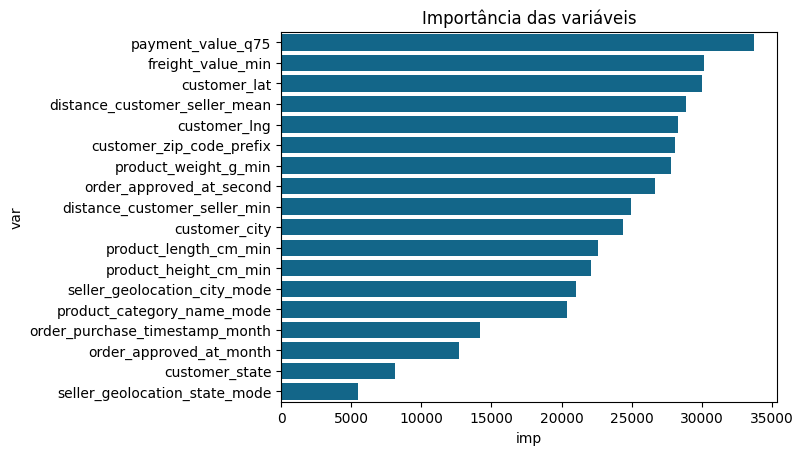

In [61]:
imp = pd.DataFrame(model.feature_importances_, X_train[list_selected_features].columns).reset_index()
imp.columns = ["var", "imp"]
imp = imp.sort_values("imp", ascending=False)

sns.barplot(x="imp", y="var", color="#006e9cff", data=imp.iloc[:30])

plt.title(f"Importância das variáveis")
plt.show()

### Shap Values

In [46]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train[list_selected_features])

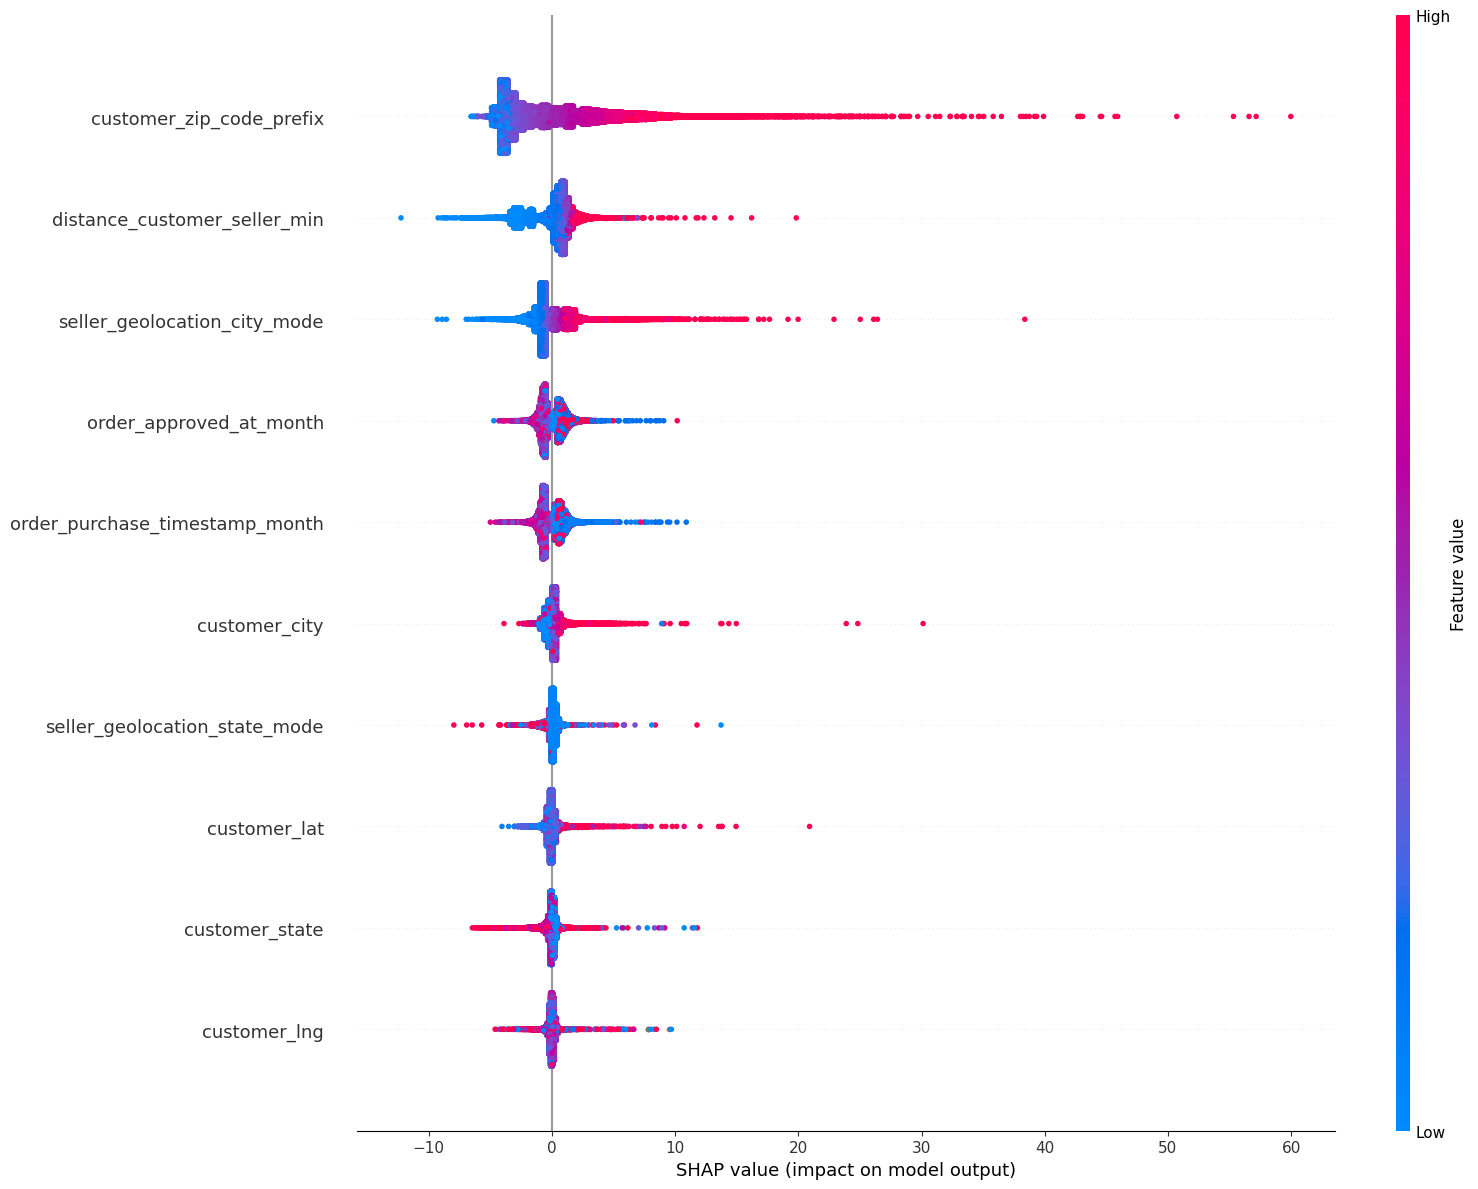

,index,impact
0,customer_zip_code_prefix,3.418187
4,distance_customer_seller_min,1.309871
1,seller_geolocation_city_mode,1.171556
9,order_approved_at_month,0.783768
7,order_purchase_timestamp_month,0.760271
2,customer_city,0.389511
8,seller_geolocation_state_mode,0.283360
5,customer_lat,0.279530
3,customer_state,0.277981
6,customer_lng,0.181293


In [47]:
shap.summary_plot(shap_values, X_train[list_selected_features], plot_size=(16, 12))

shap_df = pd.DataFrame(np.abs(shap_values), columns=list_selected_features)
shap_df = (
    pd.DataFrame(shap_df.mean(), columns=["impact"]).reset_index()
    .rename(columns={"level_0": "var"})
    .sort_values(by=["impact"], ascending=False))

display(shap_df)

## Analysis of Estimated Values

### Train Values

In [48]:
get_metrics(y_train[target], y_train['estimated_delivery_in_days'])

R2: -1.2810417739559368; RMSE: 15.080866883305696; MAE: 12.761871732624305; MAPE: 62012495350742.0


In [49]:
get_metrics(y_train[target], y_train['pred'])

R2: 0.5292506930726284; RMSE: 6.851008900627936; MAE: 4.446043629857306; MAPE: 22995239453447.363


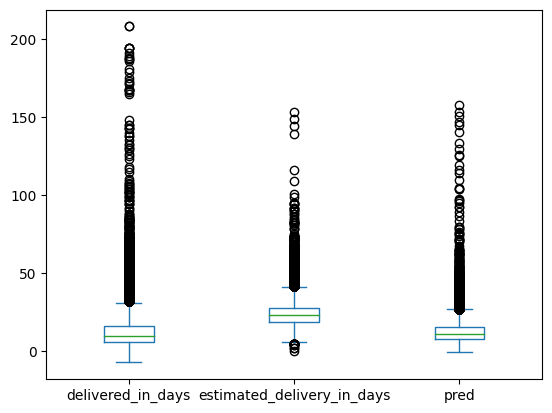

In [50]:
y_train.plot(kind='box');

### OoT Values

In [51]:
get_metrics(y_oot[target], y_oot['estimated_delivery_in_days'])

R2: -6.096547120243494; RMSE: 15.469371569468713; MAE: 12.755738321776057; MAPE: 243542505248334.34


In [52]:
get_metrics(y_oot[target], y_oot['pred'])

R2: -0.05179777103893324; RMSE: 5.955459133810177; MAE: 4.37434664616333; MAPE: 124122490917478.58


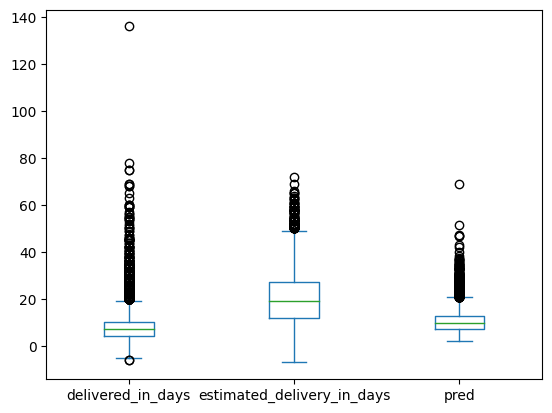

In [53]:
y_oot.plot(kind='box');

### Metrics over Time

In [54]:
df_aux = pd.concat([df_train[['time']], df_oot[['time']]], axis=0)
df_aux1 = pd.concat([y_train, y_oot], axis=0)

df_aux = pd.concat([df_aux, df_aux1], axis=1)

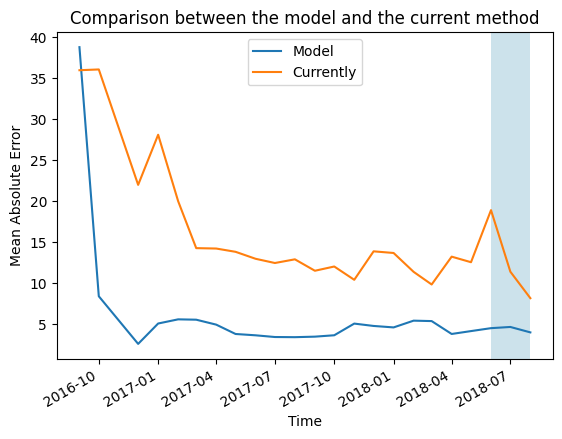

In [55]:
df_aux.groupby('time').apply(lambda i: mean_absolute_error(i[target], i['pred'])).plot(label='Model')
df_aux.groupby('time').apply(lambda i: mean_absolute_error(i[target], i['estimated_delivery_in_days'])).plot(label='Currently')

plt.axvspan("2018-06-01", "2018-08-01", facecolor="#006e9cff", alpha=0.2)

plt.title('Comparison between the model and the current method')
plt.xlabel('Time')
plt.ylabel('Mean Absolute Error')
plt.legend(loc='best');

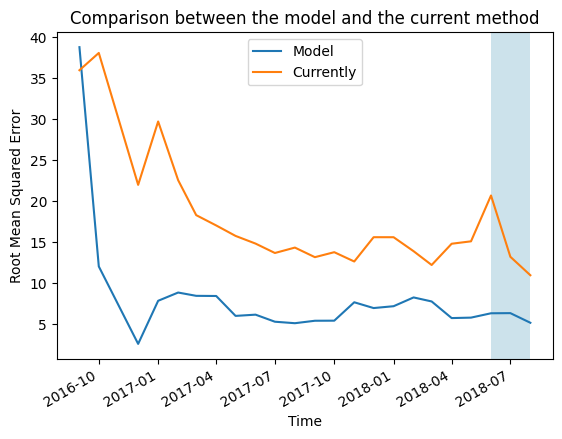

In [56]:
df_aux.groupby('time').apply(lambda i: mean_squared_error(i[target], i['pred'], squared=False)).plot(label='Model')
df_aux.groupby('time').apply(lambda i: mean_squared_error(i[target], i['estimated_delivery_in_days'], squared=False)).plot(label='Currently')

plt.axvspan("2018-06-01", "2018-08-01", facecolor="#006e9cff", alpha=0.2)

plt.title('Comparison between the model and the current method')
plt.xlabel('Time')
plt.ylabel('Root Mean Squared Error')
plt.legend(loc='best');